In [412]:
import pywt
import numpy as np
import pandas as pd
from sklearn import svm,preprocessing
import tushare as ts
import matplotlib.pyplot as plt
#正常显示画图时出现的中文和负号
from pylab import mpl
#mpl.rcParams['font.sans-serif']=['SimHei']
#mpl.rcParams['axes.unicode_minus']=False

import re

token = 'c5cba6dd1dc9c4c3578cdd046f54dfc4119fef2aabf7f998ed9a5192'
ts.set_token(token)
pro = ts.pro_api(token)

In [413]:
po = pd.read_csv('../data/DAT_XLSX_USDHKD_M1_202010.csv')
po.head()

,DateTime Stamp,Bar OPEN Bid Quote,Bar HIGH Bid Quote,Bar LOW Bid Quote,Bar CLOSE Bid Quote,Volume
0,2020-10-01 00:00,7.74991,7.74994,7.74991,7.74994,0.0
1,2020-10-01 00:01,7.74997,7.74997,7.74997,7.74997,0.0
2,2020-10-01 00:02,7.74993,7.75001,7.74993,7.75001,0.0
3,2020-10-01 00:03,7.74997,7.75001,7.74997,7.75001,0.0
4,2020-10-01 00:04,7.74991,7.75002,7.74991,7.75002,0.0


In [414]:
def get_month(dt):
    return re.findall('2020-10-(.+) ',dt)[0]

In [415]:
po['day'] = po['DateTime Stamp'].apply(get_month)
r = np.log(po.iloc[1:po.shape[0],4].values/po.iloc[0:po.shape[0]-1,4].values)
po['return'] = [0]+list(r)
po.head()

,DateTime Stamp,Bar OPEN Bid Quote,Bar HIGH Bid Quote,Bar LOW Bid Quote,Bar CLOSE Bid Quote,Volume,day,return
0,2020-10-01 00:00,7.74991,7.74994,7.74991,7.74994,0.0,01,0.000000
1,2020-10-01 00:01,7.74997,7.74997,7.74997,7.74997,0.0,01,0.000004
2,2020-10-01 00:02,7.74993,7.75001,7.74993,7.75001,0.0,01,0.000005
3,2020-10-01 00:03,7.74997,7.75001,7.74997,7.75001,0.0,01,0.000000
4,2020-10-01 00:04,7.74991,7.75002,7.74991,7.75002,0.0,01,0.000001


In [416]:
po.columns=['datetime','open','high','low','close','volumn','day','return']

In [417]:
pa = po[po.day=='11'].reset_index(drop=True)

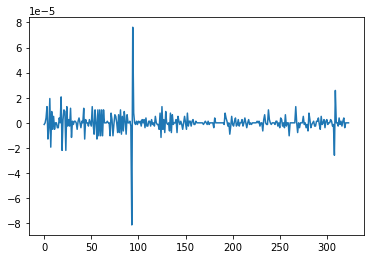

In [418]:
plt.plot(pa['return'])

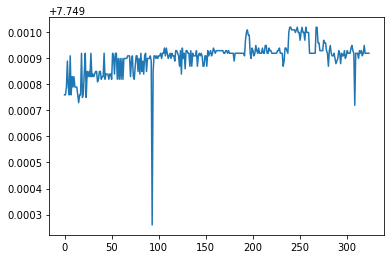

In [419]:
plt.plot(pa.close)

小波分析：  
1. Decomposition --将信号分解成N层小波  
2. Denoise --对于分解的小波，选择阈值进行去噪声处理  
3. Reconstruction --将去噪以后的小波（高频）和未处理的小波（低频）重构得到信号

In [420]:
print('查看小波函数族：',pywt.families())
print('查看sym小波族下的所有函数：',pywt.wavelist(family='sym',kind='all'))

查看小波函数族： ['haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus', 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor']
查看sym小波族下的所有函数： ['sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sym12', 'sym13', 'sym14', 'sym15', 'sym16', 'sym17', 'sym18', 'sym19', 'sym20']


In [421]:
res_4 = pywt.wavedec(np.array(pa.close),wavelet='sym8',mode='symmetric',level=4)

In [422]:
res_4_df = pd.DataFrame([res_4[0],res_4[1],res_4[2],res_4[3],res_4[4]],index=['main','high1','high2','high3','high4']).T
res_4_df.head(5)

,main,high1,high2,high3,high4
0,30.999208,-0.000090,-0.000025,-0.000031,-0.000120
1,30.999204,0.000002,0.000046,-0.000044,0.000035
2,30.999199,0.000029,-0.000023,0.000023,0.000042
3,30.999188,0.000015,-0.000064,0.000047,-0.000024
4,30.999205,-0.000035,0.000105,-0.000084,0.000021


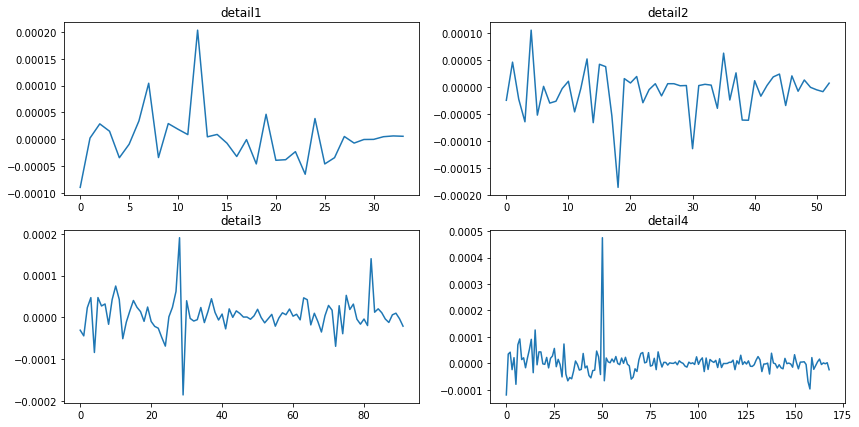

In [423]:
fig = plt.figure(figsize=(14,7))      #设置图形大小
for j in [1,2,3,4]:
    plt.subplot(2,2,j)
    plt.plot(range(len(res_4[j])),res_4[j])
    plt.title('detail'+str(j))

jump detection

In [424]:
print(len(pa.close))
for i in range(5):
    print(f'{i} layer\'s length: {len(res_4[i])}')

324
0 layer's length: 34
1 layer's length: 34
2 layer's length: 53
3 layer's length: 92
4 layer's length: 169


$$D_n = d \sqrt{2\ log\  n},where\ d is\ the\ median\ of\ \{|Y_{j_n,k},k=1,...,2^{j_n}|\}\ divided\ by\ 0.6745$$

In [425]:
Dn=[]
for i in range(1,5):
    n=len(pa.close)
    d = np.median(np.abs(res_4[i]))
    Di = d * np.sqrt(3*np.log(n))
    Di /= 0.6745
    Dn.append(Di)
    
Dn

[0.00016015458315048965,
 0.00012074384169209399,
 0.00010856472854487695,
 9.122175702503952e-05]

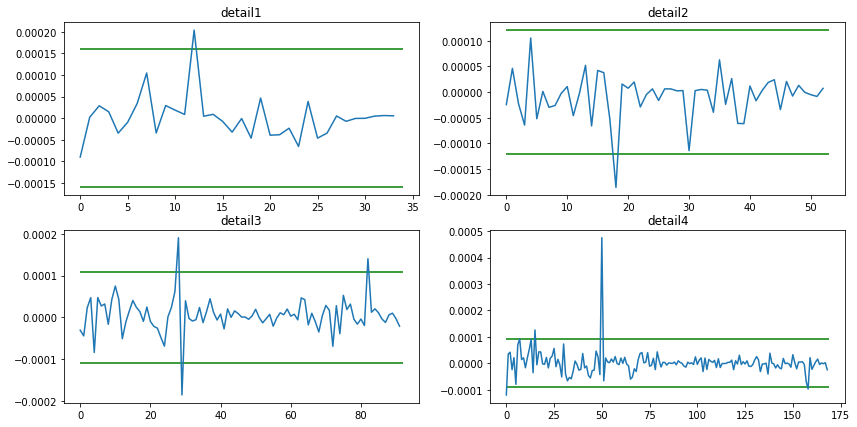

In [426]:
fig = plt.figure(figsize=(14,7))      #设置图形大小
for j in [1,2,3,4]:
    plt.subplot(2,2,j)
    plt.plot(range(len(res_4[j])),res_4[j])
    plt.title('detail'+str(j))
    plt.hlines(y=Dn[j-1],xmin=0,xmax=len(res_4[j]),color='green')
    plt.hlines(y=-Dn[j-1],xmin=0,xmax=len(res_4[j]),color='green')

In [427]:
jump_point = []
wholelength = len(pa.close)
for i in range(1,5):
    length = len(res_4[i])
    index= (np.round(np.array(np.where(abs(res_4[i])>abs(Dn[i-1])))*wholelength/length)-3).astype(int).tolist()[0]
    jump_point+=index

jump_point.sort()
jump_point = jump_point[1:]
len(jump_point)

9

In [428]:
jump_point

[10, 26, 93, 96, 99, 107, 111, 286, 300]

In [429]:
markindex=np.array([False]*wholelength)
markindex[jump_point]=True

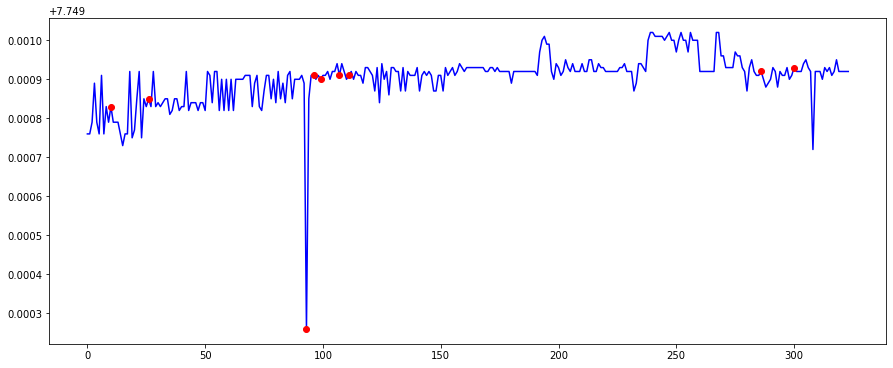

In [430]:
plt.figure(figsize=(15, 6))
plt.plot(pa.close, label='close',c='b')
plt.plot(pa.close, 'o', label='outliers',markevery=markindex,c='r')

remove jump

In [431]:
delta = np.int(wholelength * 1/np.sqrt(wholelength))

In [432]:
l=0
for point in jump_point:
    right = point+delta if point+delta<wholelength else wholelength-1
    left = point-delta if point-delta>-1 else 0
    yp = pa.close[point:right].mean()
    yn = pa.close[left:point].mean()
    li=yp-yn
    l+=li
    
l

0.00019711111111497814

降噪处理

1. 按绝对值排序signal
2. 计算每个值的风险：  
    $$Risk_j = (N-2*j+ (N-j)*(signal_{N-j}) + \sum_{i=0}^j(signal_i))/N$$

In [433]:
def threshold_cal(signal):
    '''regrsure 无偏风险估计阈值'''
    signal = abs(signal)
    signal.sort()
    signal = signal**2
    list_risk = [];N=len(signal)
    for j in range(N):
        if j==0:
            risk_j = 1+signal[N-1]
        else:
            risk_j = (N-2*j+ (N-j)*(signal[N-j]) + sum(signal[:j]))/N
        list_risk.append(risk_j)
    k=np.array(list_risk).argmin()
    threshold = np.sqrt(signal[k])
    return threshold

In [434]:
for j in [3,4]:     #对于low freq信号进行阈值处理
    signal = np.array(res_4[j])
    threshold = threshold_cal(signal)       #固定阈值方法 np.sqrt(2*np.log(len(signal)))
    res_4[j] = pywt.threshold(signal, threshold, 'soft')
    
rec_4 = pywt.waverec(res_4, 'sym8')

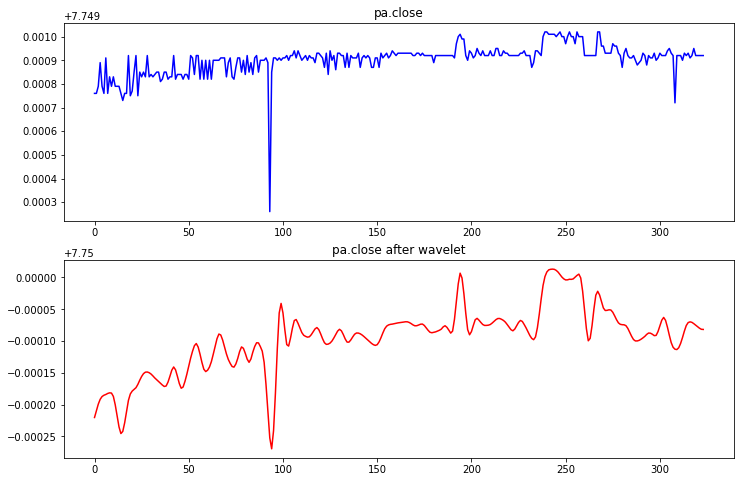

In [435]:
#pa['wavelet_close'] = rec_4
fig = plt.figure(figsize=(12,8))      #设置图形大小
plt.subplot(2,1,1)
plt.plot(pa.index,pa.close,color='blue')
plt.title('pa.close')
plt.subplot(2,1,2)
plt.plot(rec_4,color='red')
plt.title('pa.close after wavelet')
plt.show()

In [436]:
res_44 = pywt.wavedec(np.array(rec_4),wavelet='sym8',mode='symmetric',level=4)
Dn=[]
for i in range(1,5):
    n=len(rec_4)
    d = np.median(np.abs(res_44[i]))
    Di = d * np.sqrt(3*np.log(n))
    Di /= 0.6745
    Dn.append(Di)
    
Dn

[0.0001300005247768705,
 0.00011596271531356776,
 1.238108238984753e-14,
 4.648261035634799e-15]

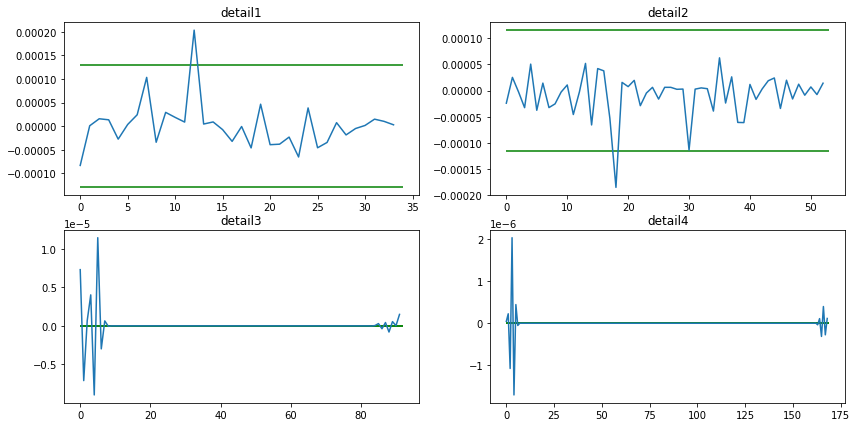

In [437]:
fig = plt.figure(figsize=(14,7))      #设置图形大小
for j in [1,2,3,4]:
    plt.subplot(2,2,j)
    plt.plot(range(len(res_44[j])),res_44[j])
    plt.title('detail'+str(j))
    plt.hlines(y=Dn[j-1],xmin=0,xmax=len(res_44[j]),color='green')
    plt.hlines(y=-Dn[j-1],xmin=0,xmax=len(res_44[j]),color='green')

In [438]:
jump_point = []
wholelength = len(rec_4)
for i in range(3,5):
    length = len(res_44[i])
    index= (np.round(np.array(np.where(abs(res_44[i])>abs(Dn[i-1])))*wholelength/length)-3).astype(int).tolist()[0]
    jump_point+=index

jump_point.sort()
jump_point = jump_point[1:]
len(jump_point)

35

In [439]:
markindex=np.array([False]*len(rec_4))
markindex[jump_point]=True

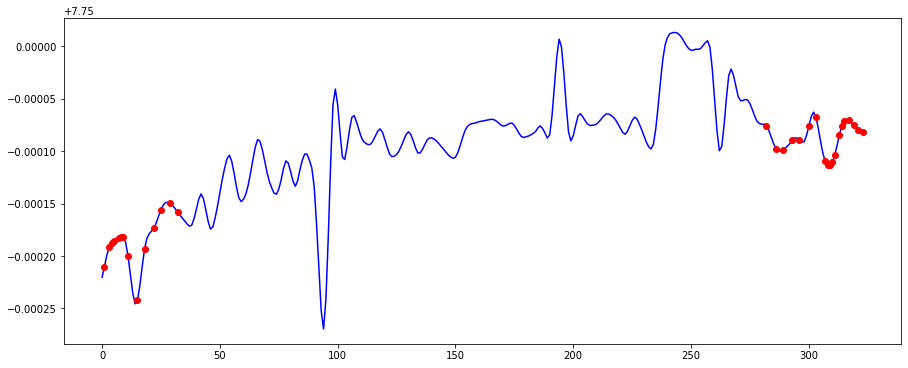

In [440]:
plt.figure(figsize=(15, 6))
plt.plot(rec_4, label='close',c='b')
plt.plot(rec_4, 'o', label='outliers',markevery=markindex,c='r')